In [1]:
import glob, os, re
import maboss

Matplotlib is building the font cache; this may take a moment.
ipylab module is not installed, menus and toolbar are disabled.


In [2]:
# Map used: https://github.com/colomoto/colomoto-docker/raw/master/tutorials/CaSQ/Apoptosis_VS_SSA_AN.xml
model = maboss.gsparser.loadSBML('Apoptosis_signaling_pathway_revised_Panther.sbml', cfg_filename=None, use_sbml_names=True, cmaboss=False)

In [3]:
all_node_names = (model.network.names)
print(all_node_names)

['TRADD', 'FADD', 'Complex_br_TNFR1TNF_complex', 'Complex_br_FADDTRADD_complex', 'RAIDD', 'TRAF2', 'RIP', 'Complex_br_TRADDRAIDD_br_TRAF2RIP_complex', 'I_kappa_B', 'NF_kappa_B', 'Complex_br_I_kappa_BNF_kappa_B_complex', 'Complex_br_FoscJun_complex_c5_1', 'JNK_phosphorylated', 'Complex_br_FoscJun_complex_c5', 'Complex_br_FASFAS_br_ligand_complex', 'DAXX', 'Complex_br_FASDAXX_br_FADDFAS_br_ligand_complex', 'Bag', 'Bclw', 'Bi1', 'Bak', 'Bax', 'Complex_br_BaxBak_complex', 'Bik', 'Bcl2', 'Complex_br_Bcl2Bik_complex', 'GranzymeB', 'IGFR2', 'Complex_br_IGFR2GranzymeB_complex', 'TNF', 'TNFR1', 'MADD', 'Complex_br_TNFR1TNF_br_MADD_complex', 'Complex_br_TNFR2TNF_complex', 'Complex_br_TNFR2TNF_br_TRAF2_complex', 'TNFR2', 'TRAILR', 'TRAIL', 'Complex_br_TRAILRTRAIL_complex', 'FAS_br_ligand', 'FAS', 'Caspase8', 'SODD', 'Flip', 'PI3K', 'PKCs', 'GCK', 'NIK', 'CytochromeC_Mitochondria', 'BclxL', 'CytochromeC_c5', 'Bid_Mitochondria', 'Bim', 'Bad', 'BclxS', 'Bok', 'Unknown_br_adaptor_unknown', 'Caspase10

In [4]:
# Define the output nodes.
maboss.set_output(model, ['Proapoptotic_phenotype']) #,'Antiapoptosis_phenotype'])

In [18]:
# 'FAS', 'TNF', 'Bclw', 'Proapoptopic_phenotype', 'Antiapoptosis_phenotype'

In [5]:
# Manually define the Input nodes, based on CellDesigner > CASQ > CytoScape (directed network)
input_nodes = ['FAS' , 'TNF' , 'Bclw', 'Bax']
# the Internal nodes will be all input_nodes minus the Input nodes
internal_nodes = list(set(all_node_names) - set(input_nodes))

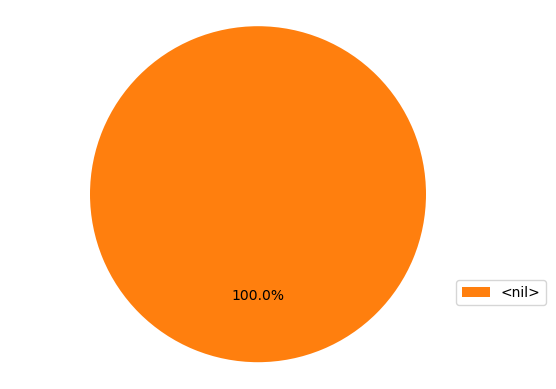

In [6]:
# Simulate the model with random condition >> Need to be confirmed.
res = model.run()
res.plot_piechart()

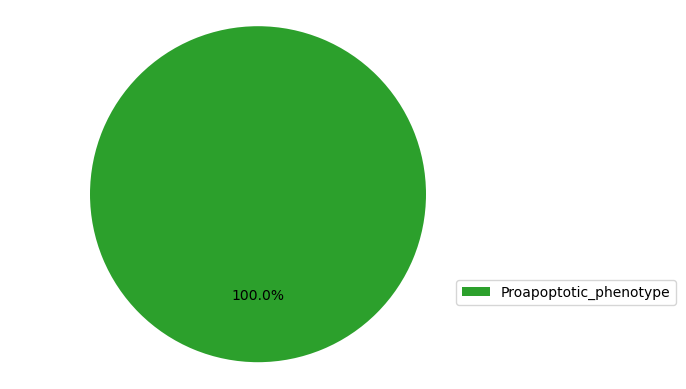

In [22]:
# Simulate - ALL nodes get 50% possibilty of ON (or OFF).
all_nodes_50_ON_model = model.copy()
for node in all_node_names:
    all_nodes_50_ON_model.network.set_istate(node, [0,1])
all_nodes_50_ON_model.run().plot_piechart()

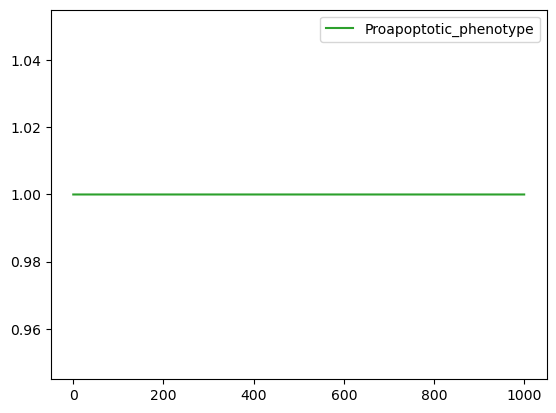

In [23]:
# Simulate - ALL nodes get 50% possibilty of ON (or OFF).
# This plot is node-level, showing how fast (x=time) each node becomes ON.
all_nodes_50_ON_model.run().plot_node_trajectory()

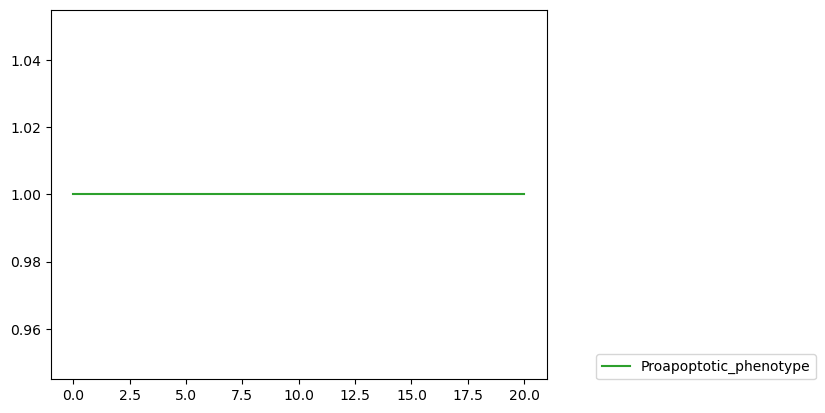

In [24]:
# Simulate - ALL nodes get 50% possibilty of ON (or OFF).
# This plot is model-level, showing the fractions of cells end up in different fates over time.
all_nodes_50_ON_model.run().plot_trajectory(until=20)

In [25]:
from maboss.pipelines import simulate_single_mutants, filter_sensitivity
import matplotlib.pyplot as plt

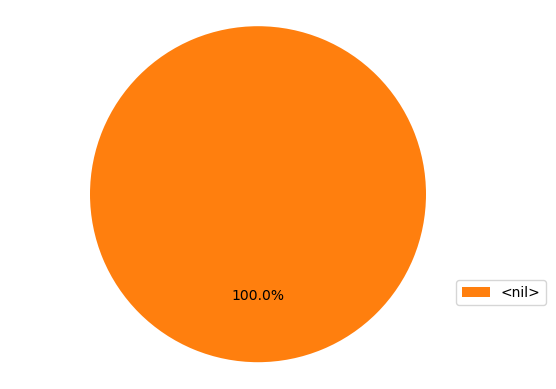

In [35]:
model_input_all_on = model.copy()
for nodes in input_nodes:
    model_input_all_on.network.set_istate(nodes, [0,1])

res_all_on = model_input_all_on.run()

res_all_on.plot_piechart()

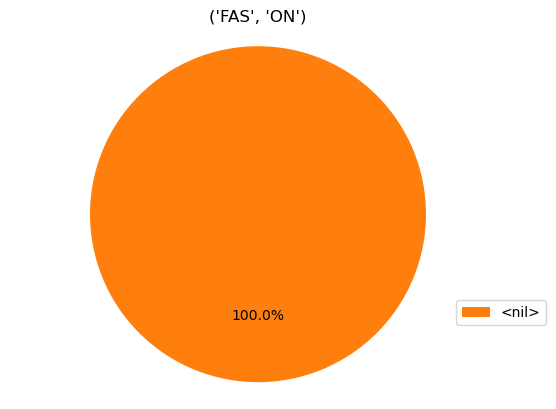

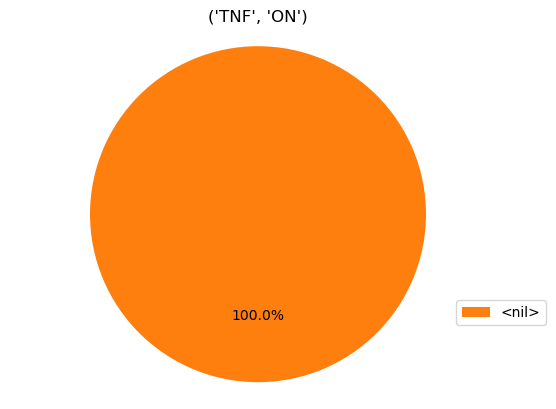

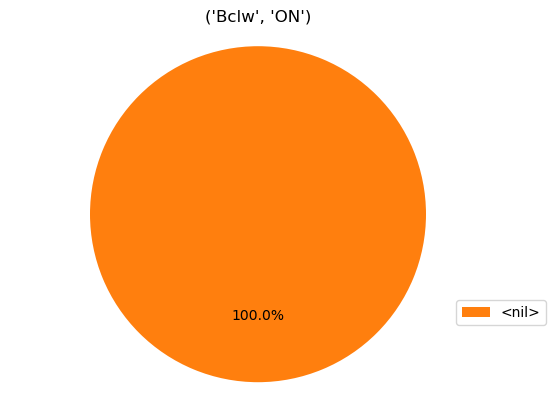

In [26]:
# Caution: the built-in sensitivity analysis may not be ideal for scanning Input nodes.
# the sensitivity analysis is instead for internal nodes.
# Note: in the answer template, the candidate_nodes are all internal nodes, not input nodes.

# Simulate through each input node one at a time (ON)
model_individual_ON = model.copy()
simulation_individual_ON = simulate_single_mutants(model_individual_ON, input_nodes, 'ON')
for simulation_individual_ON, result in simulation_individual_ON.items():
    result.plot_piechart()
    plt.title(simulation_individual_ON)

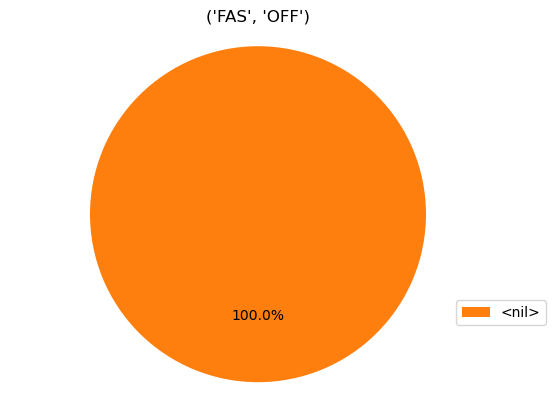

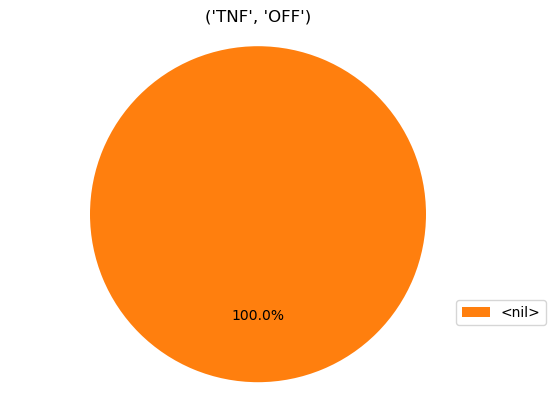

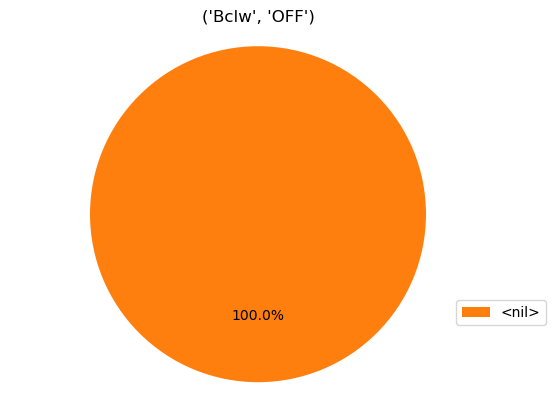

In [27]:
# Simulate through each input node one at a time (OFF)
model_individual_OFF = model.copy()
simulation_individual_OFF = simulate_single_mutants(model_individual_OFF, input_nodes, 'OFF')
for simulation_individual_OFF, result in simulation_individual_OFF.items():
    result.plot_piechart()
    plt.title(simulation_individual_OFF)

In [28]:
from maboss.pipelines import simulate_double_mutants

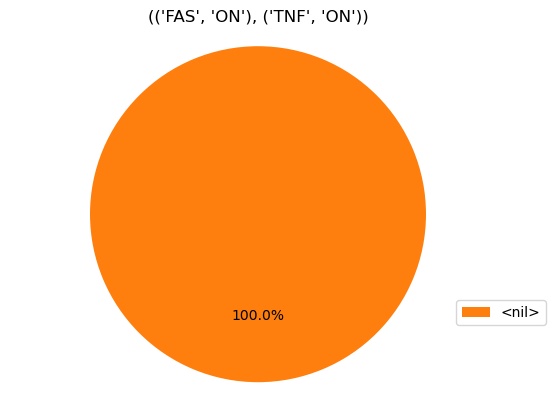

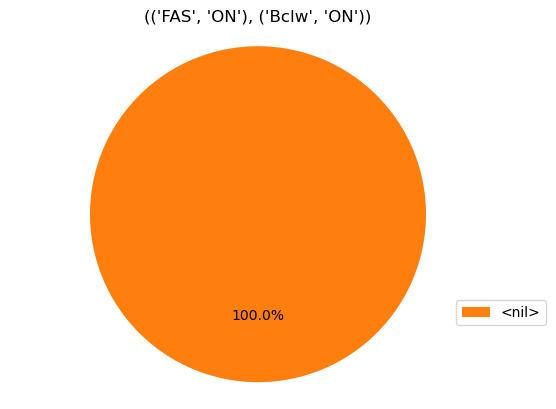

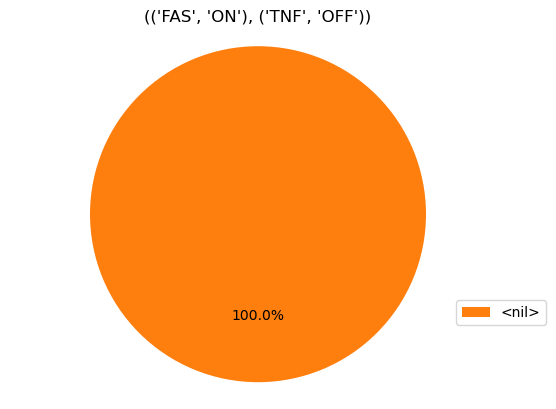

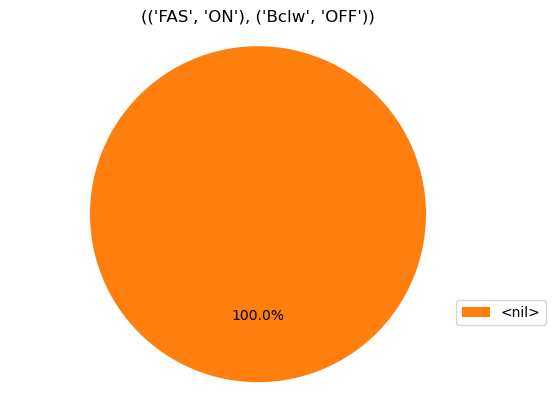

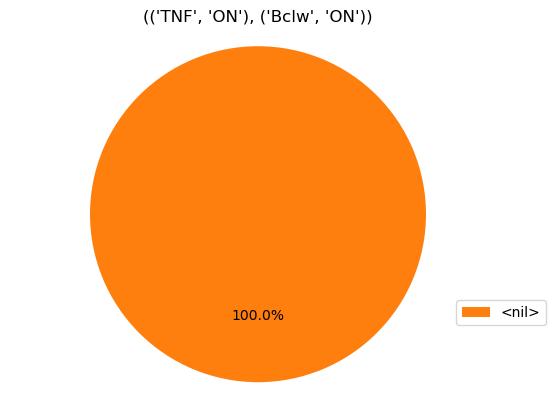

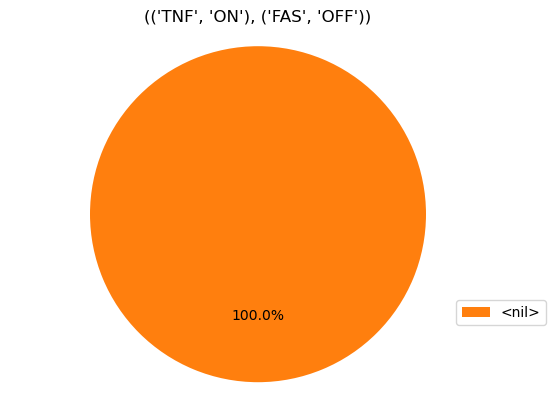

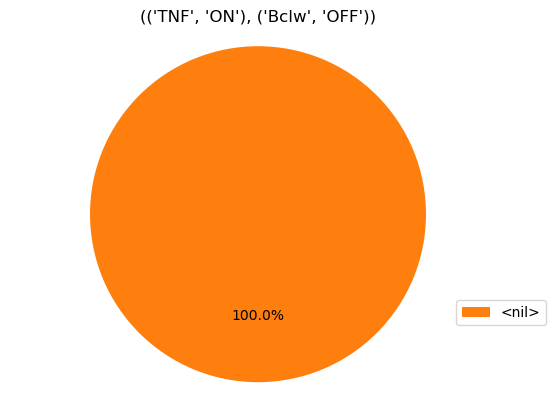

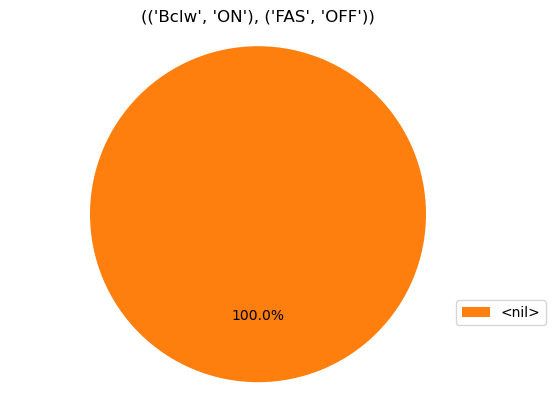

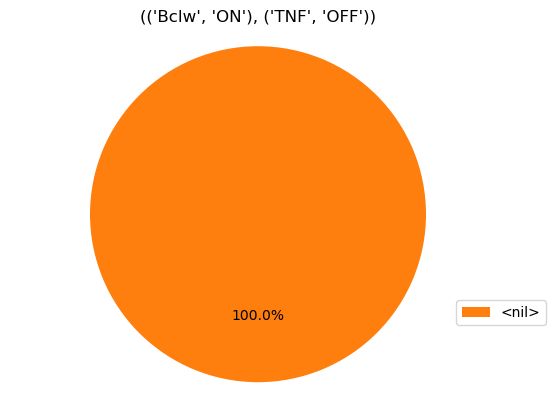

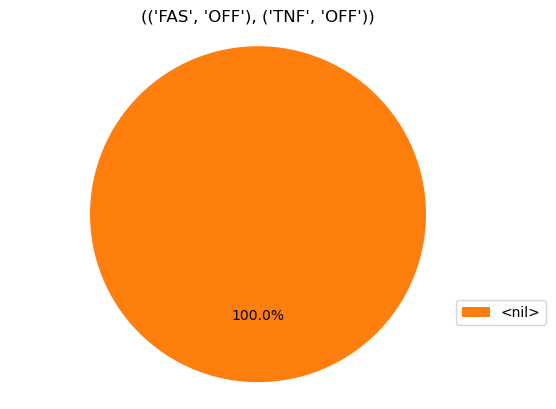

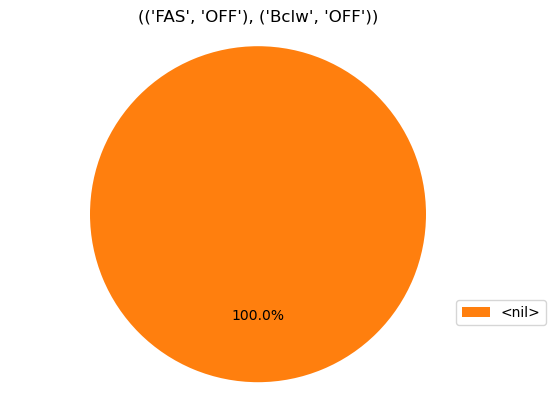

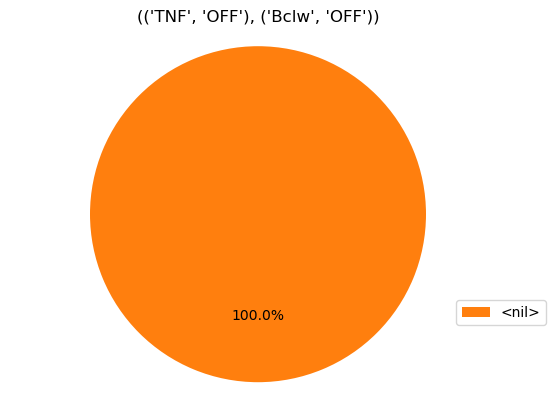

In [29]:
# Simulate through each input node TWO at a time
model_double_ONOFF = model.copy()
simulation_double_ONOFF = simulate_double_mutants(model_double_ONOFF, input_nodes, sign='BOTH', cmaboss=False)
for simulation_double_ONOFF, result in simulation_double_ONOFF.items():
    result.plot_piechart()
    plt.title(simulation_double_ONOFF)

In [ ]:
# Ignore below for now

In [ ]:
import math
import itertools
import pandas as pd

In [148]:
# Whether a SINGLE input activates apoptosis.
single_input_model = model.copy()
single_input_results = {}
# Iterature through all input nodes, One at a time.
for single_input_node in input_nodes:
    # we need to turn off other nodes (otherwise we get increasing ON nodes)
    for n in input_nodes: 
        single_input_model.network.set_istate(n, [1, 0])
    single_input_model.network.set_istate(single_input_node, [0, 1])
    res_single_input_model = single_input_model.run()
    df = res_single_input_model.get_states_probtraj()
    # Compute probibility of Apoptosis ON
    apoptosis_on = df.loc[:, df.columns.str.contains(f'Apoptosis=1')].sum().sum()
    single_input_results[single_input_node] = (1-apoptosis_on, apoptosis_on)

df = pd.DataFrame([
    {'Inputs': single_input_node, 'p_apoptosis': prob}
    for single_input_node, prob in single_input_results.items()
])
df

,Inputs,p_apoptosis
0,SARSM,"(1.0, 0.0)"
1,FASFASL_complex,"(1.0, 0.0)"
2,TNFATNFR1_complex,"(1.0, 0.0)"
3,APAF1,"(1.0, 0.0)"
4,TRADD,"(1.0, 0.0)"
5,Procasp9,"(1.0, 0.0)"
6,SARSE7a,"(1.0, 0.0)"
7,SARS3a,"(1.0, 0.0)"


In [150]:
double_input_model = model.copy()
double_input_results = {}
for double_input_nodes in itertools.combinations(input_nodes, 2):
    for n in input_nodes:
        double_input_model.network.set_istate(n, [1,0])
    for n in double_input_nodes:
        double_input_model.network.set_istate(n, [0,1])
    res_double_input_model = double_input_model.run()
    df = res_double_input_model.get_states_probtraj()

    apoptosis_on = df.loc[:, df.columns.str.contains('Apoptosis=1')].sum().sum()
    double_input_results[double_input_nodes] = (1-apoptosis_on, apoptosis_on)

df_double = pd.DataFrame(
    {
        'Inputs': ' + '.join(pair),
        'p_apoptosis': p_on,
    }
    for pair, (_, p_on) in double_input_results.items()
)

In [151]:
df_double

,Inputs,p_apoptosis
0,SARSM + FASFASL_complex,0.0
1,SARSM + TNFATNFR1_complex,0.0
2,SARSM + APAF1,0.0
3,SARSM + TRADD,0.0
4,SARSM + Procasp9,0.0
5,SARSM + SARSE7a,0.0
6,SARSM + SARS3a,0.0
7,FASFASL_complex + TNFATNFR1_complex,0.0
8,FASFASL_complex + APAF1,0.0
9,FASFASL_complex + TRADD,0.0


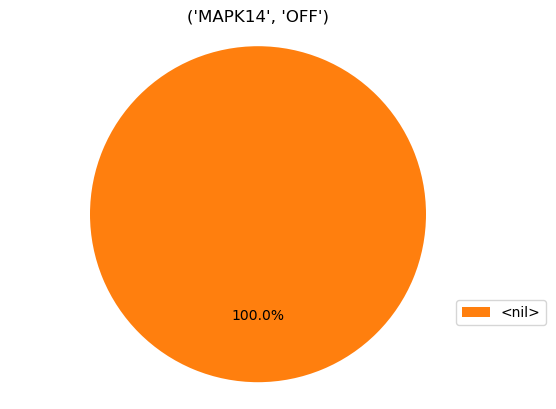

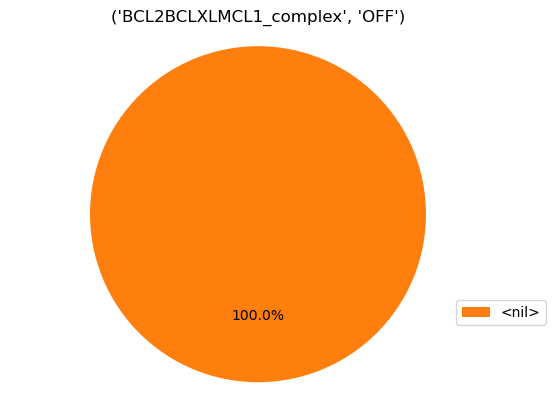

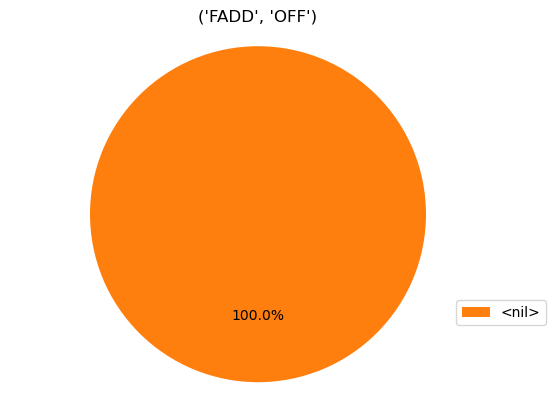

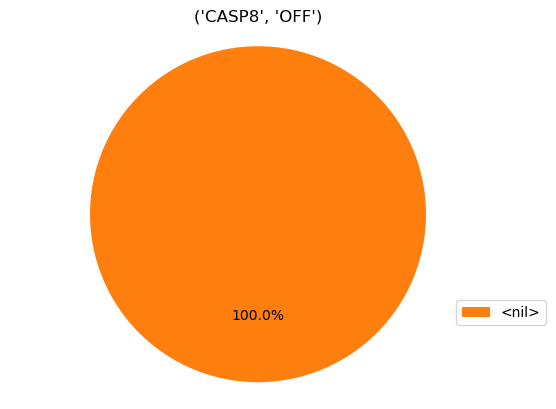

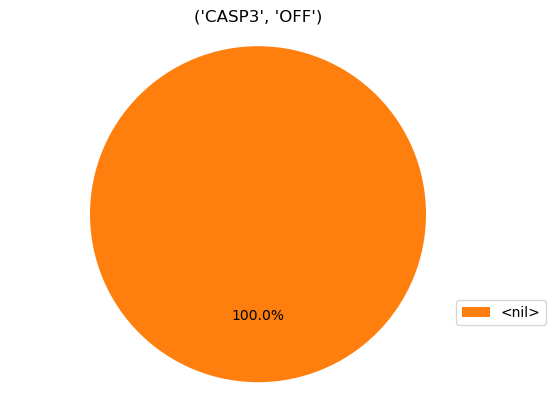

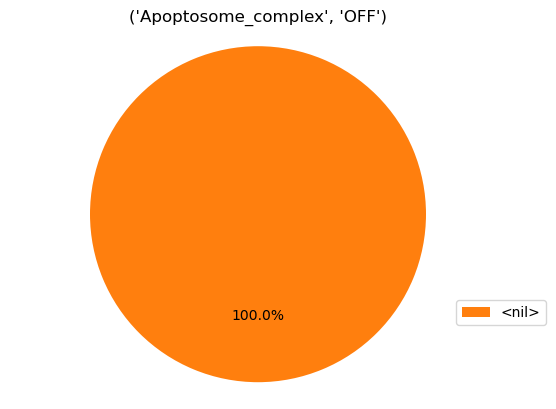

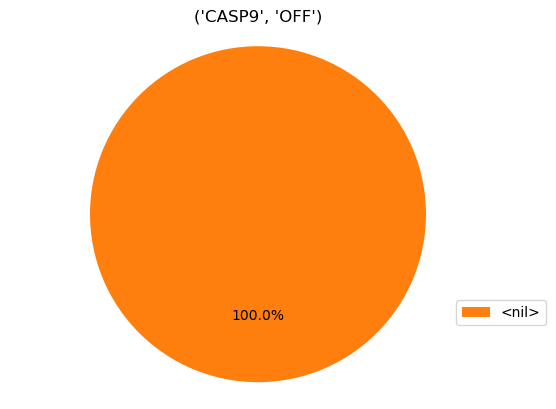

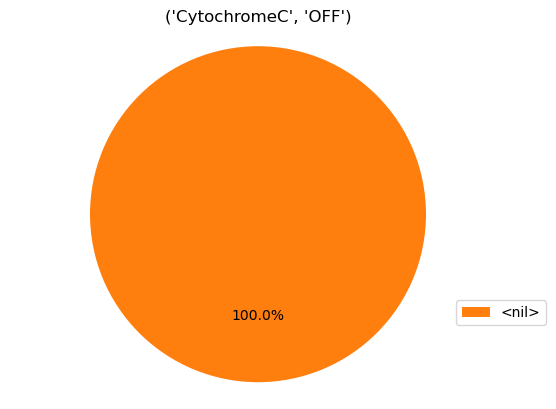

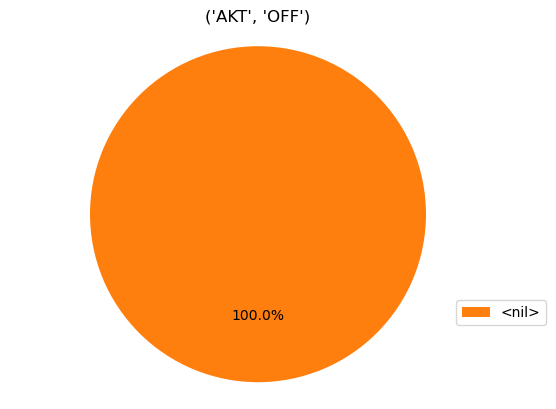

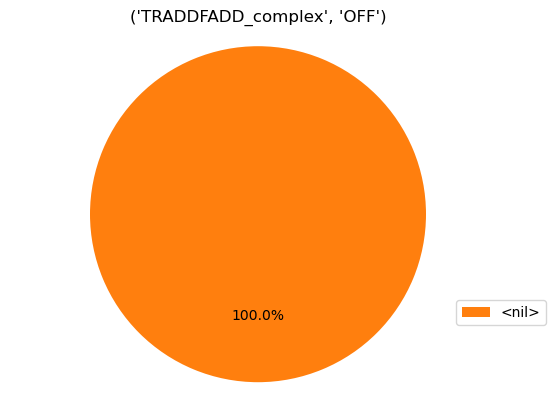

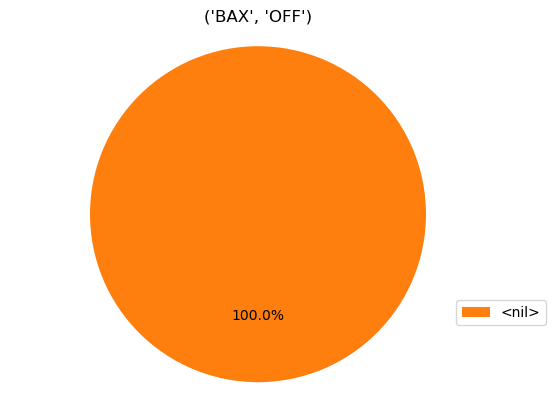

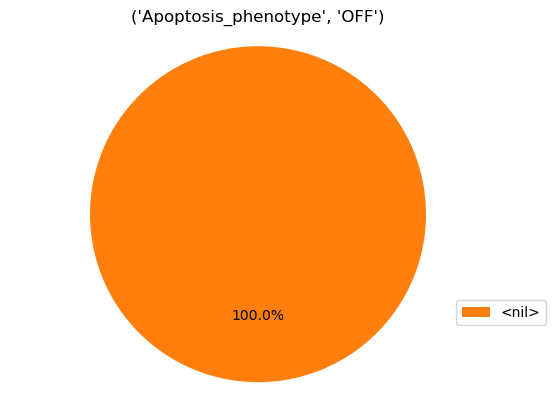

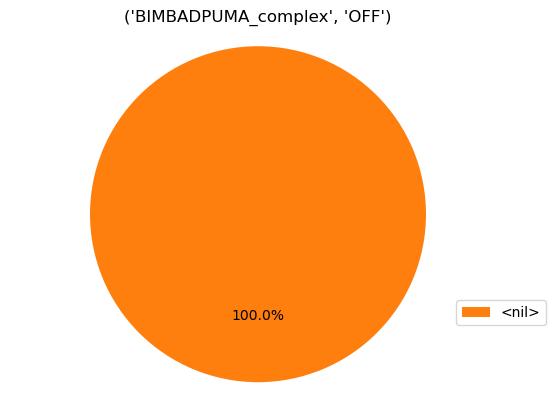

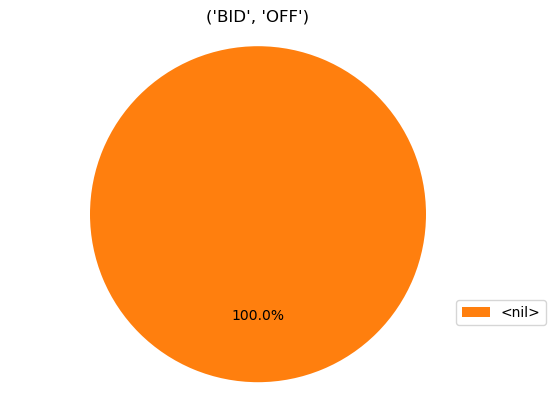

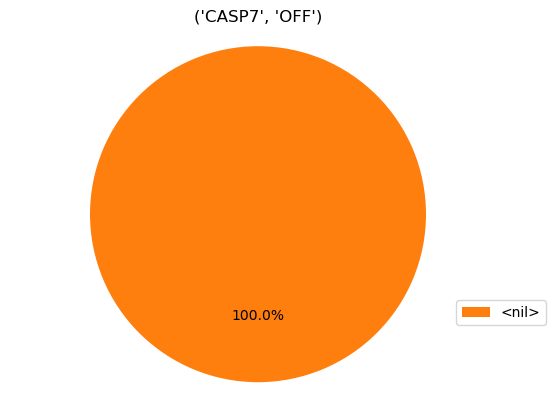

In [155]:
# Simulate through each INTERNAL node one at a time (ON)
single_internal_mutants_model = model.copy()
simulate_single_internal_mutants = simulate_single_mutants(single_internal_mutants_model, internal_nodes, 'OFF')
for simulate_single_internal_mutants, result in simulate_single_internal_mutants.items():
    result.plot_piechart()
    plt.title(simulate_single_internal_mutants)